# Propuesta de trabajo

## Participantes

* Cristobal Cancino
* Tomás Cortés
* Bruno Martinez

## Presentación de los datos, definición de variables y contexto de la problemática.

Se utilizará una base de datos sobre proteinas entregada por _Research Collaboratory for Structural Bioinformatics (RCSB)_ de _Protein Data Bank (PDB)_, la cual es un depósito de coordenadas atómicas y otra información que describe proteínas y otras macromoléculas biológicas importantes. Los biólogos estructurales utilizan métodos como la cristalografía de rayos X, la espectroscopia de RMN y la microscopía crioelectrónica para determinar la ubicación de cada átomo en relación con los demás en la molécula. Luego depositan esta información, que luego es anotada y publicada públicamente en el archivo por wwPDB.

### Motivación 
El PDB en constante crecimiento es un reflejo de la investigación que se lleva a cabo en los laboratorios de todo el mundo. Esto puede hacer que el uso de la base de datos en la investigación y la educación sea emocionante y desafiante. Las estructuras están disponibles para muchas de las proteínas y ácidos nucleicos involucrados en los procesos centrales de la vida, por lo que puede ir al archivo de PDB para encontrar estructuras para ribosomas, oncogenes, dianas de fármacos e incluso virus completos. Sin embargo, puede ser un desafío encontrar la información que necesita, ya que la PDB archiva tantas estructuras diferentes. A menudo encontrará múltiples estructuras para una molécula determinada, o estructuras parciales, o estructuras que han sido modificadas o inactivadas de su forma nativa.

Recuperado de [Structural Protein Sequence](https://www.kaggle.com/shahir/protein-data-set?select=pdb_data_no_dups.csv)

In [2]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from scipy import stats
from scipy.stats import norm, skew, kurtosis
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  AdaBoostClassifier,ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib inline
#alt.data_transformers.disable_max_rows()

### Estudio de la base de datos pdb_data_no_dups.csv

In [3]:
data_path = os.path.join("data", "pdb_data_no_dups.csv")
pdb_no_dups = pd.read_csv(data_path)
#sum(pdb_no_dups['classification'].value_counts()[:10]) / pdb_no_dups['classification'].count()
pdb_no_dups.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


Esta base de datos contiene las siguientes columnas

1. **structureid**: Indexación para identificar la estructura en particular.
2. **clasification**: Estructura en estudio.
3. **experimentalTechnique**: Técnica usada para determinar la ubicación relativa entre cada átomo de la molecula.
4. **macromoleculeType**: Tipo de macromolecula correspondiente a la estructura.
5. **residueCount**: Número de residuos, es decir, el número de monómeros que componen la macromolécula.
6. **resolution**: Resolución del microscopío. Para cada resolución, se tiene la siguiente interpretación:

| Resolucion | Interpretación                                                                                                                                                                                                              |
|------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| >4.0       | Coordenadas individuales sin significado                                                                                                                                                                                    |
| 3.0 - 4.0  | Plegamiento posiblemente correcto, pero comúnmente con errores. Algunas cadenas laterales poseen mal los rotámeros.                                                                                                         |
| 2.5 - 3.0  | Plegamiento bien dilucidado salvo en algunos pliegues superficiales, mal modelados. Algunas cadenas laterales largas (Lys, Glu, Gln) y otraqs cortas (Ser, Val, Thr) mal orientadas.                                        |
| 2.0 - 2.5  | El número de cadenas laterales con un rotámero incorrecto es mucho menor. Los errores, pequeños, son detectados normalmente. Los pliegues superficiales están bastante bien definidos. Los ligandos y el agua son visibles. |
| 1.5 - 2.0  | Pocos residuos poseen mal rotámero. Los errores pequeños son detectados. Los pliegues incorrectos son muy raros, incluso en superficie.                                                                                     |
| 0.5 - 1.5  | En general, todo está corrctamente resuelto. Las librerías de rotámeros y los estudios geométricos se hacen a este nivel de precisión.                                                                                      |

7. **structureMoleculeWeight**: Masa molar de la estructura
8. **cristalizationMethod**: Método de critalización. Aquellos experimentos que no consideran cristalización les corresponde NaN.
9. **crystalizationTemperature**: Temperatura de cristalización. Idem.
10. **densityMatthews**: Densidad de Matthews, dada por $$\frac{\text{volumen}}{\text{peso molecular} * Z * X},$$ donde $Z$ es el número de unidades asimétricas en la unidad celular y $X$ es el número de moleculas en la unidad asimétrica.
11. **densitityPercentSol**: Porcentaje de densidad de la solución.
12. **pdbxDetails**: Detalles extra del experimento.
13. **phValue**: Valor del pH.
14. **publicationYear**: Año de publicación.

### Estudio de la base de datos pdb_data_seq.csv

In [4]:
data_path = os.path.join("data", "pdb_data_seq.csv")
pdb_seq = pd.read_csv(data_path)
pdb_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


### Esta base de datos contiene las siguientes columnas

1. **structureid**: Indexación para identificar la estructura en particular.
2. **chainId**: Cadena de la estructura.
3. **sequence**: Secuencia molecular de la macromolécula.
4. **macromoleculeType**: Tipo de macromolecula correspondiente a la estructura
5. **residueCount**: Número de residuos, es decir, el número de monómeros que componen la macromolécula.



# ¿Cuál es la pregunta que deseamos resolver?



¿Podemos predecir la columna ``secuencia`` o la columna ``clasificacion`` utilizando el resto de features mediante modelos?

## Análisis estadístico de los datos.

In [5]:
pdb_no_dups.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
structureId,141401.0,140911,3NO0,4,,,,,,,
classification,141399.0,5050,HYDROLASE,20915,,,,,,,
experimentalTechnique,141401.0,33,X-RAY DIFFRACTION,126432,,,,,,,
macromoleculeType,137636.0,13,Protein,127798,,,,,,,
residueCount,141401.0,,,,825.375,2136.46,0,226,414,820,313236
resolution,128589.0,,,,2.26381,1.41088,0.48,1.8,2.1,2.5,70
structureMolecularWeight,141401.0,,,,112079,569015,314.38,26128.6,47477.8,94084.8,9.77305e+07
crystallizationMethod,96242.0,549,"VAPOR DIFFUSION, HANGING DROP",53870,,,,,,,
crystallizationTempK,97039.0,,,,290.968,9.54108,4,290,293,295,398
densityMatthews,124724.0,,,,2.67027,0.78374,0,2.21,2.49,2.91,99


In [6]:
pdb_no_dups.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
dtype: object

In [7]:
pdb_seq.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
structureId,467304.0,140250,3J3Q,1356,,,,,,,
chainId,467294.0,2836,A,135187,,,,,,,
sequence,467276.0,104812,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...,5112,,,,,,,
residueCount,467304.0,,,,6173.43,23645.6,0,456,1131,4342,313236
macromoleculeType,432487.0,13,Protein,345180,,,,,,,


In [8]:
pdb_seq.dtypes

structureId          object
chainId              object
sequence             object
residueCount          int64
macromoleculeType    object
dtype: object

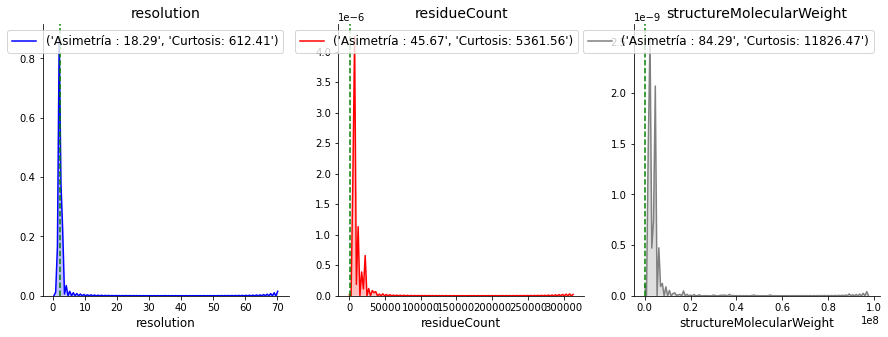

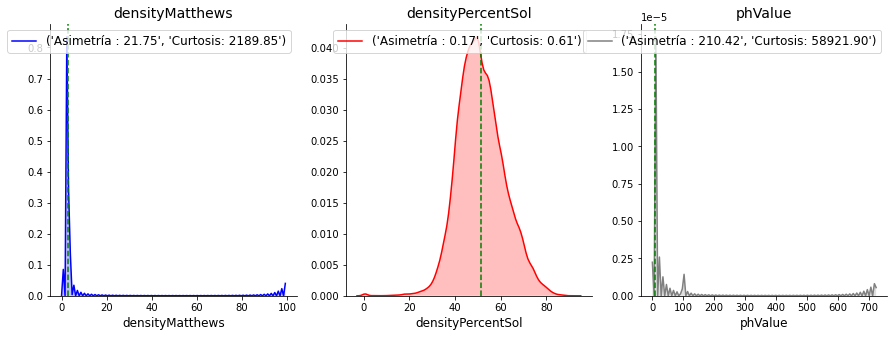

In [9]:
def triple_distribution_plot(df, input1, input2, input3):
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    
    sns.kdeplot(df[input1],ax = ax1,color ='blue',shade=True,
                label=("Asimetría : %.2f"%(df[input1].skew()),
                       "Curtosis: %.2f"%(df[input1].kurtosis())))
    sns.kdeplot(df[input2], ax = ax2,color='r',shade=True,
                label=("Asimetría : %.2f"%(df[input2].skew()),
                       "Curtosis: %.2f"%(df[input2].kurtosis())))
    sns.kdeplot(df[input3], ax = ax3,color='gray',shade=True,
                label=("Asimetría : %.2f"%(df[input3].skew()),
                       "Curtosis: %.2f"%(df[input3].kurtosis())))
    
    axes = [ax1,ax2,ax3]
    input = [input1,input2,input3]
    
    for j in range(len(axes)):
        axes[j].set_xlabel(input[j],color='black',fontsize=12)
        axes[j].set_title(input[j], fontsize=14)
        axes[j].axvline(df[input[j]].mean() , color ='g',linestyle = '--')
        axes[j].legend(loc ='upper right',fontsize=12,ncol=2)
    sns.despine()
    
    return plt.show()

triple_distribution_plot(pdb_no_dups, 'resolution','residueCount','structureMolecularWeight')
triple_distribution_plot(pdb_no_dups, 'densityMatthews','densityPercentSol','phValue')

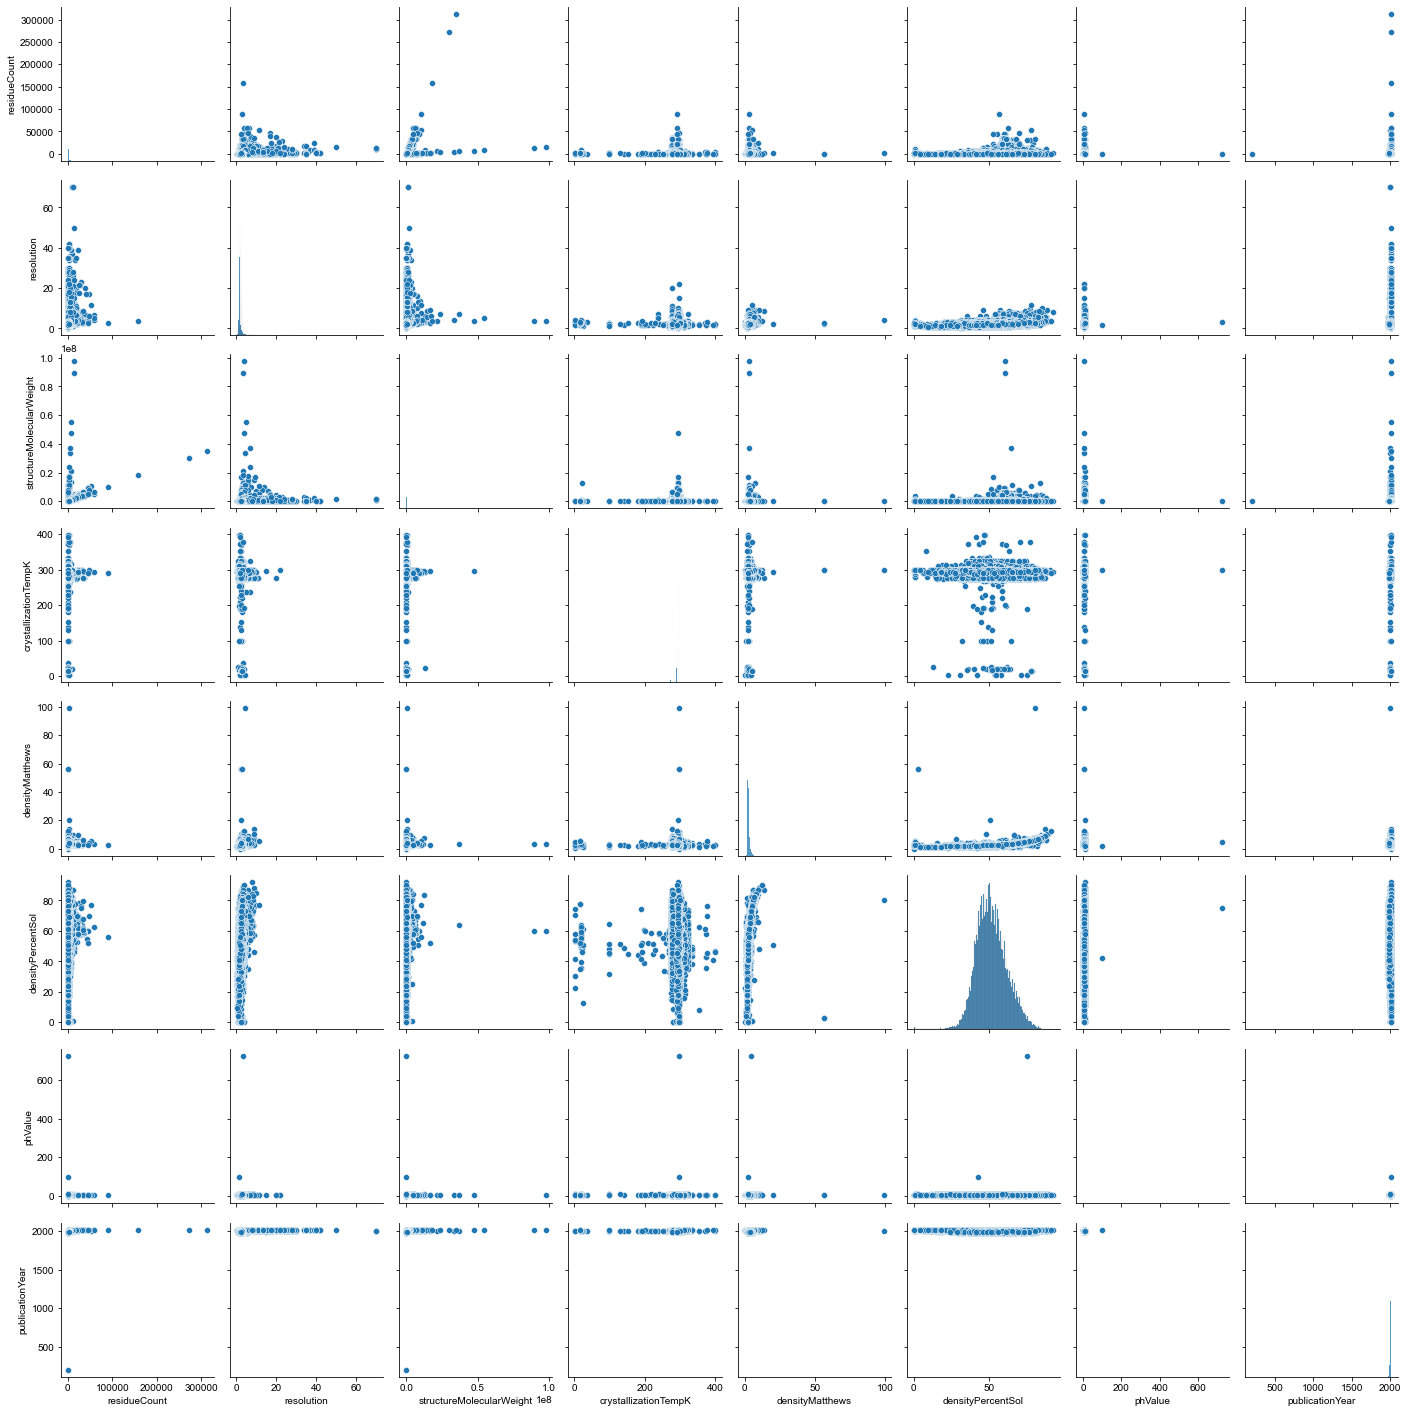

In [9]:
sns.pairplot(pdb_no_dups)
sns.set(style="ticks", color_codes=True)

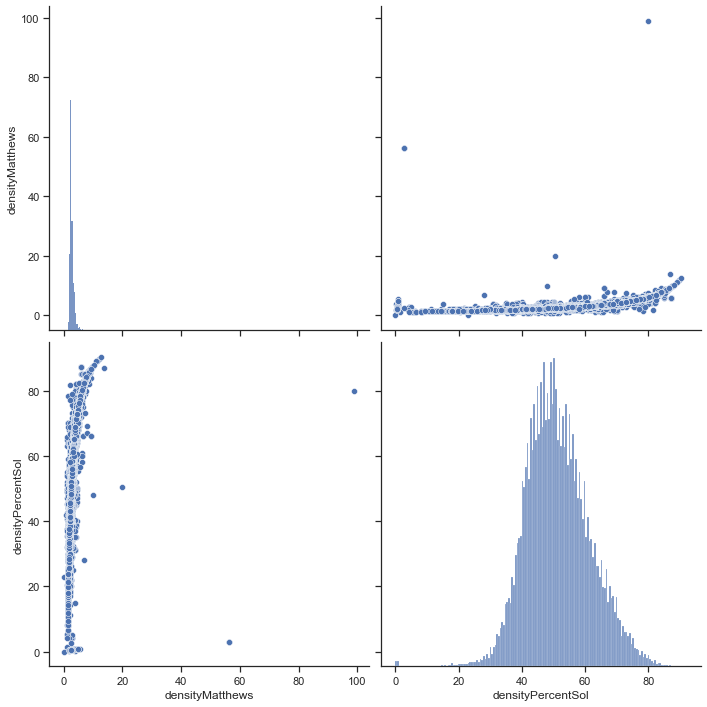

In [10]:
sns.pairplot(pdb_no_dups[['densityMatthews','densityPercentSol']], height = 5)
sns.set(style="ticks", color_codes=True)

## ¿Hay que realizar preprocesamiento e inputación de datos faltantes?

Si, esto es pues algunas entradas se tienen valores no esperados, por ejemplo, en la columna de pH, se encontró un valor 200, mientras que en la columna publicationYear se tiene por ejemplo al año 200.

Además, se dropearan algunas columnas que no son de nuestro interés estudiar, las cuales son por ejemplo "crystallizationMethod", "crystallizationTempK", "phValue", "pdbxDetails", "publicationYear". Esto debido a la importante cantidad de valores perdidos y por el contenido de estas columnas (correspondiente a años innecesarios o comentarios)

In [10]:
df_merge = pdb_no_dups.merge(pdb_seq,how='inner',on='structureId')
df_merge.rename({'macromoleculeType_x':'macromoleculeType','residueCount_y':'residueCount'},axis=1,inplace=True)
df_merge.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)

df_isnull = pd.DataFrame(round((df_merge.isnull().sum().sort_values(ascending=False)/df_merge.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
df_isnull

,Columns,% of Missing Data
0,crystallizationMethod,33.200000
1,crystallizationTempK,32.600000
2,phValue,27.700000
3,pdbxDetails,18.200000
4,densityMatthews,17.300000
5,densityPercentSol,17.300000
6,publicationYear,12.200000
7,macromoleculeType,7.600000
8,resolution,4.600000
9,sequence,0.000000


Eliminando las primeras 6 columnas con mayor porcentaje de datos no válidos, se tiene que

In [11]:
df_merge = df_merge.dropna(subset=["crystallizationMethod","crystallizationTempK","phValue","pdbxDetails", "publicationYear"])

df_isnull = pd.DataFrame(round((df_merge.isnull().sum().sort_values(ascending=False)/df_merge.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
df_isnull

,Columns,% of Missing Data
0,macromoleculeType,6.100000
1,densityPercentSol,4.400000
2,densityMatthews,4.300000
3,resolution,0.000000
4,sequence,0.000000
5,chainId,0.000000
6,residueCount,0.000000
7,publicationYear,0.000000
8,phValue,0.000000
9,pdbxDetails,0.000000


### Análisis de las 10 mejores clasificaciones

In [12]:
dfaux = df_merge["classification"].value_counts()[:10].index
df1 = df_merge[lambda df: df["classification"].isin(dfaux)]
df1.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
structureId,126214.0,36168,5VYC,222,,,,,,,
classification,126214.0,10,RIBOSOME,27866,,,,,,,
experimentalTechnique,126214.0,10,X-RAY DIFFRACTION,126128,,,,,,,
macromoleculeType,116722.0,8,Protein,96545,,,,,,,
resolution,126166.0,,,,2.54906,0.807638,0.7,2,2.5,3,15
structureMolecularWeight,126214.0,,,,939369,1.69296e+06,2138.67,68021.6,163582,735331,7.65538e+06
crystallizationMethod,126214.0,256,"VAPOR DIFFUSION, HANGING DROP",69788,,,,,,,
crystallizationTempK,126214.0,,,,290.512,9.5259,4,291,293,295,398
densityMatthews,120536.0,,,,2.90779,0.869227,0.97,2.37,2.76,3.3,99
densityPercentSol,120270.0,,,,55.3483,9.78617,0.52,48,55.35,62.65,88


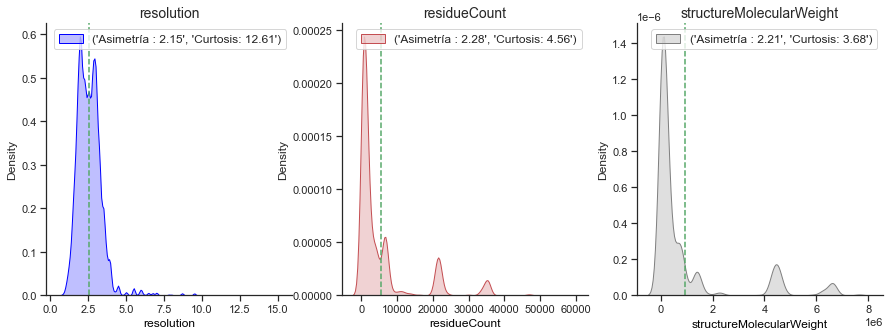

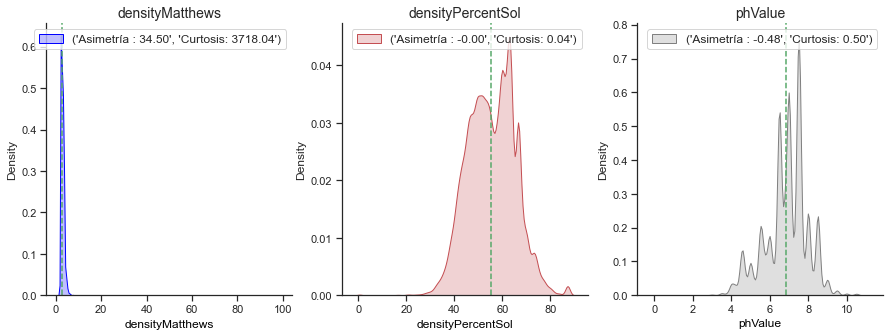

In [14]:
triple_distribution_plot(df1, 'resolution','residueCount','structureMolecularWeight')
triple_distribution_plot(df1, 'densityMatthews','densityPercentSol','phValue')

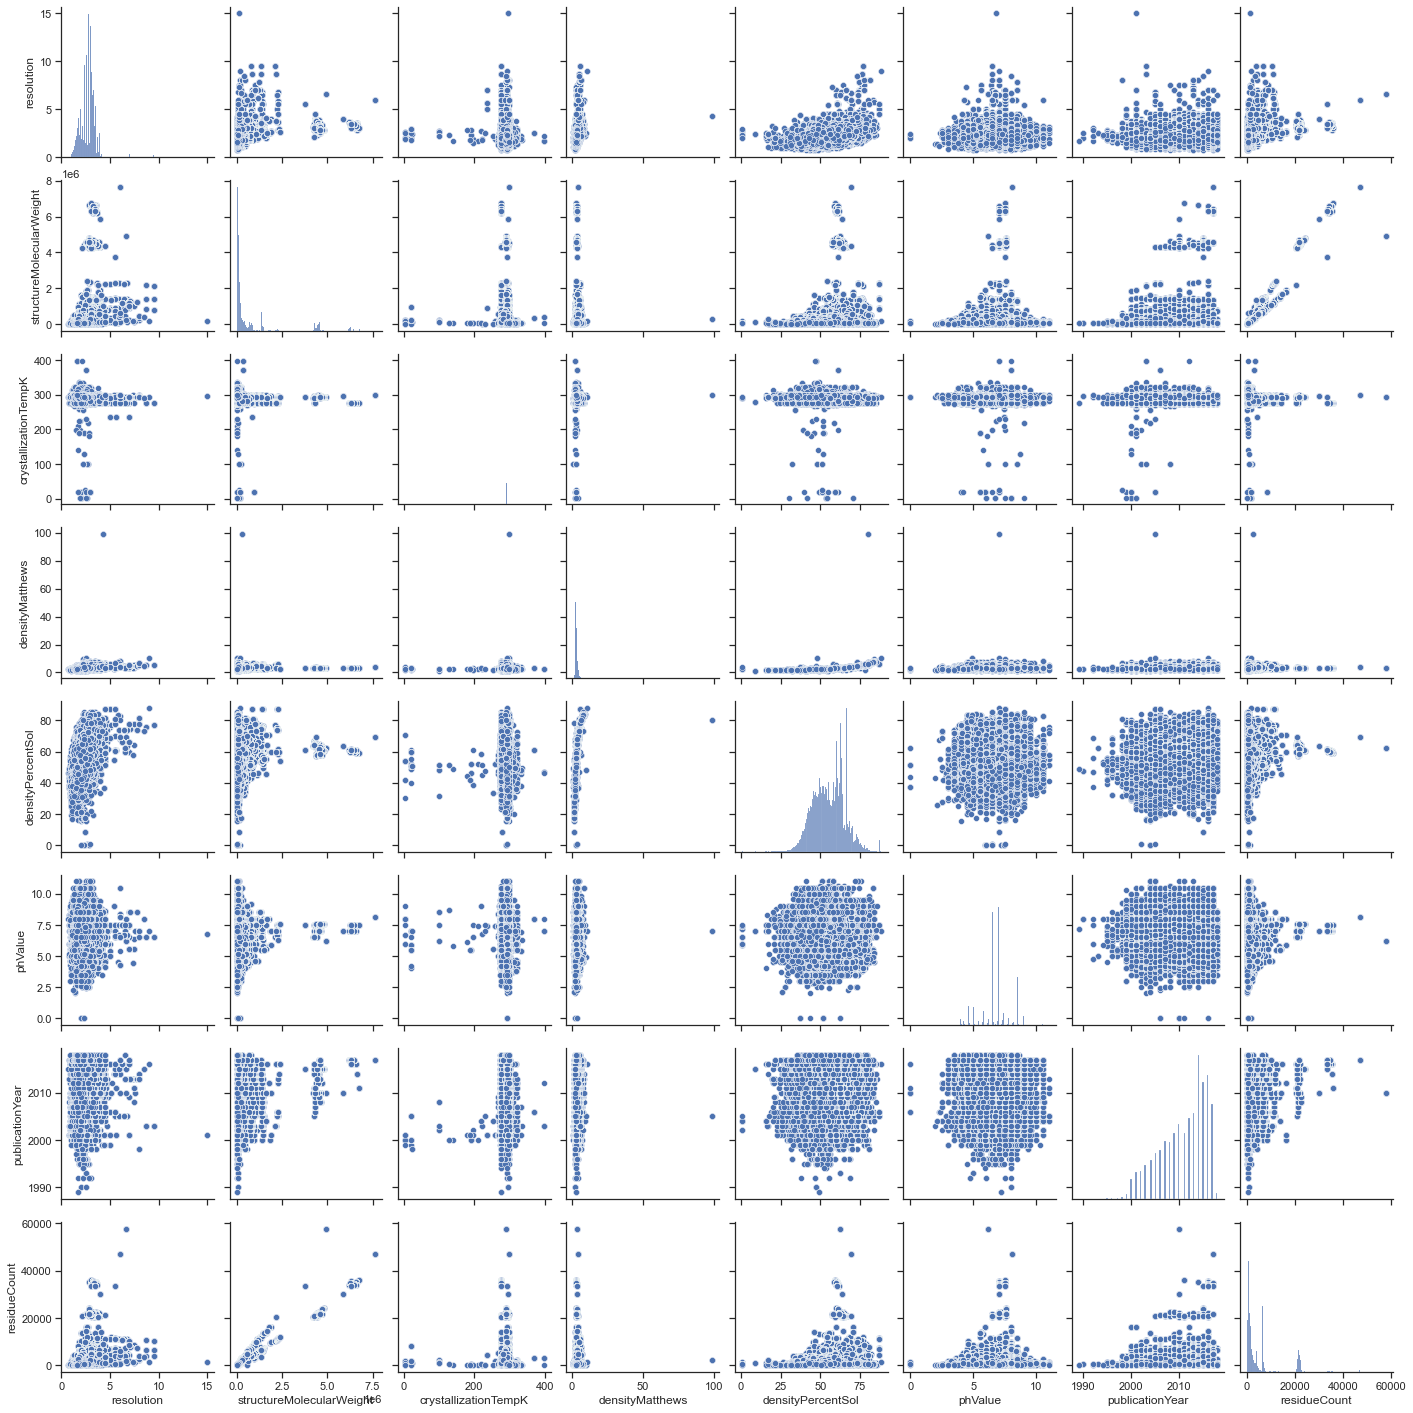

In [15]:
sns.pairplot(df1)
sns.set(style="ticks", color_codes=True)

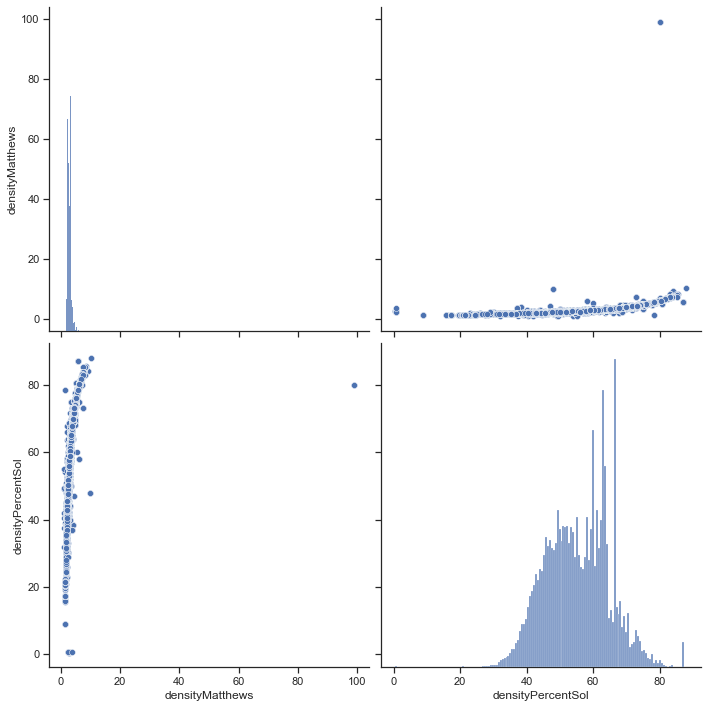

In [16]:
sns.pairplot(df1[['densityMatthews','densityPercentSol']], height = 5)
sns.set(style="ticks", color_codes=True)

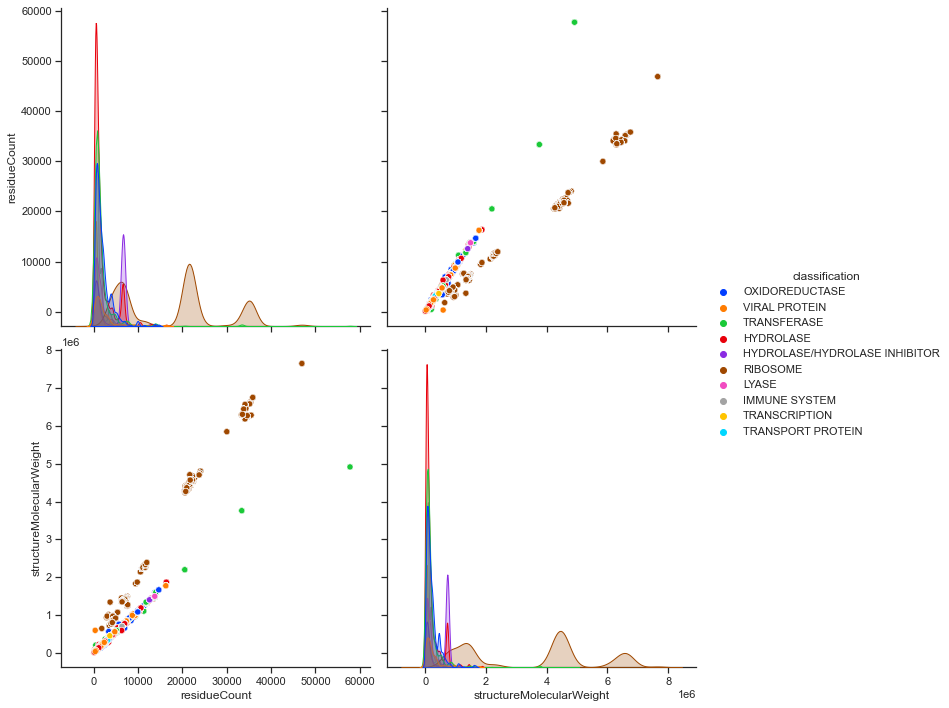

In [17]:
sns.pairplot(df1, 
             vars=['residueCount', 'structureMolecularWeight'], 
             palette = "bright",#tab10
             hue="classification", 
             height = 5)
sns.set(style="ticks", color_codes=True)

**Análisis estadístico de las 10 mejores clasificaciones**

In [13]:
dfaux = df_merge["sequence"].value_counts()[:10].index
df10bs = df_merge[lambda df: df["sequence"].isin(dfaux)]
df10bs.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
structureId,4674.0,1281,4V99,360,,,,,,,
classification,4674.0,26,HYDROLASE/HYDROLASE INHIBITOR,2086,,,,,,,
experimentalTechnique,4674.0,3,X-RAY DIFFRACTION,4662,,,,,,,
macromoleculeType,4299.0,2,Protein,3939,,,,,,,
resolution,4667.0,,,,2.44678,0.571363,0.94,1.99,2.7,2.9,3.58
structureMolecularWeight,4674.0,,,,1.2708e+06,2.58348e+06,14331.2,36720.6,732598,735647,1.01355e+07
crystallizationMethod,4674.0,30,"VAPOR DIFFUSION, HANGING DROP",2648,,,,,,,
crystallizationTempK,4674.0,,,,292.598,2.49555,273,291,293,293,318
densityMatthews,4669.0,,,,3.11096,0.661592,1.54,2.44,3.67,3.67,3.89
densityPercentSol,4669.0,,,,58.3558,10.1522,20.31,49.5,66.52,66.52,68.42


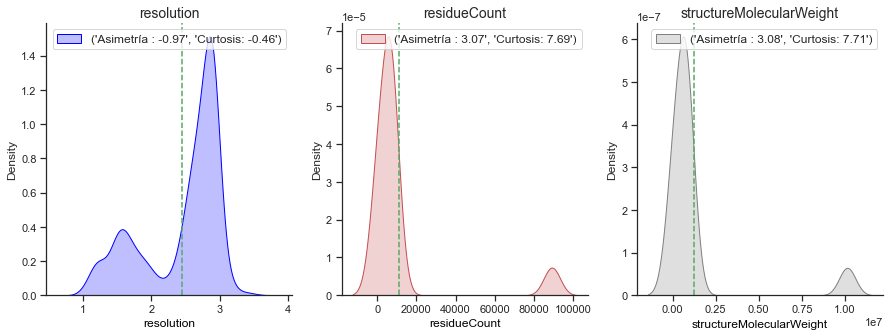

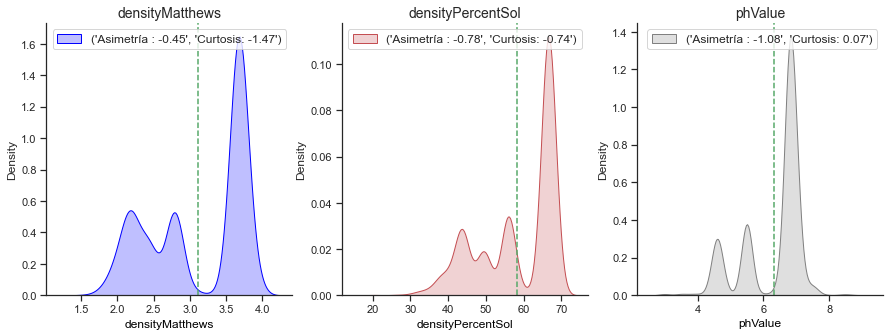

In [19]:
triple_distribution_plot(df10bs, 'resolution','residueCount','structureMolecularWeight')
triple_distribution_plot(df10bs, 'densityMatthews','densityPercentSol','phValue')

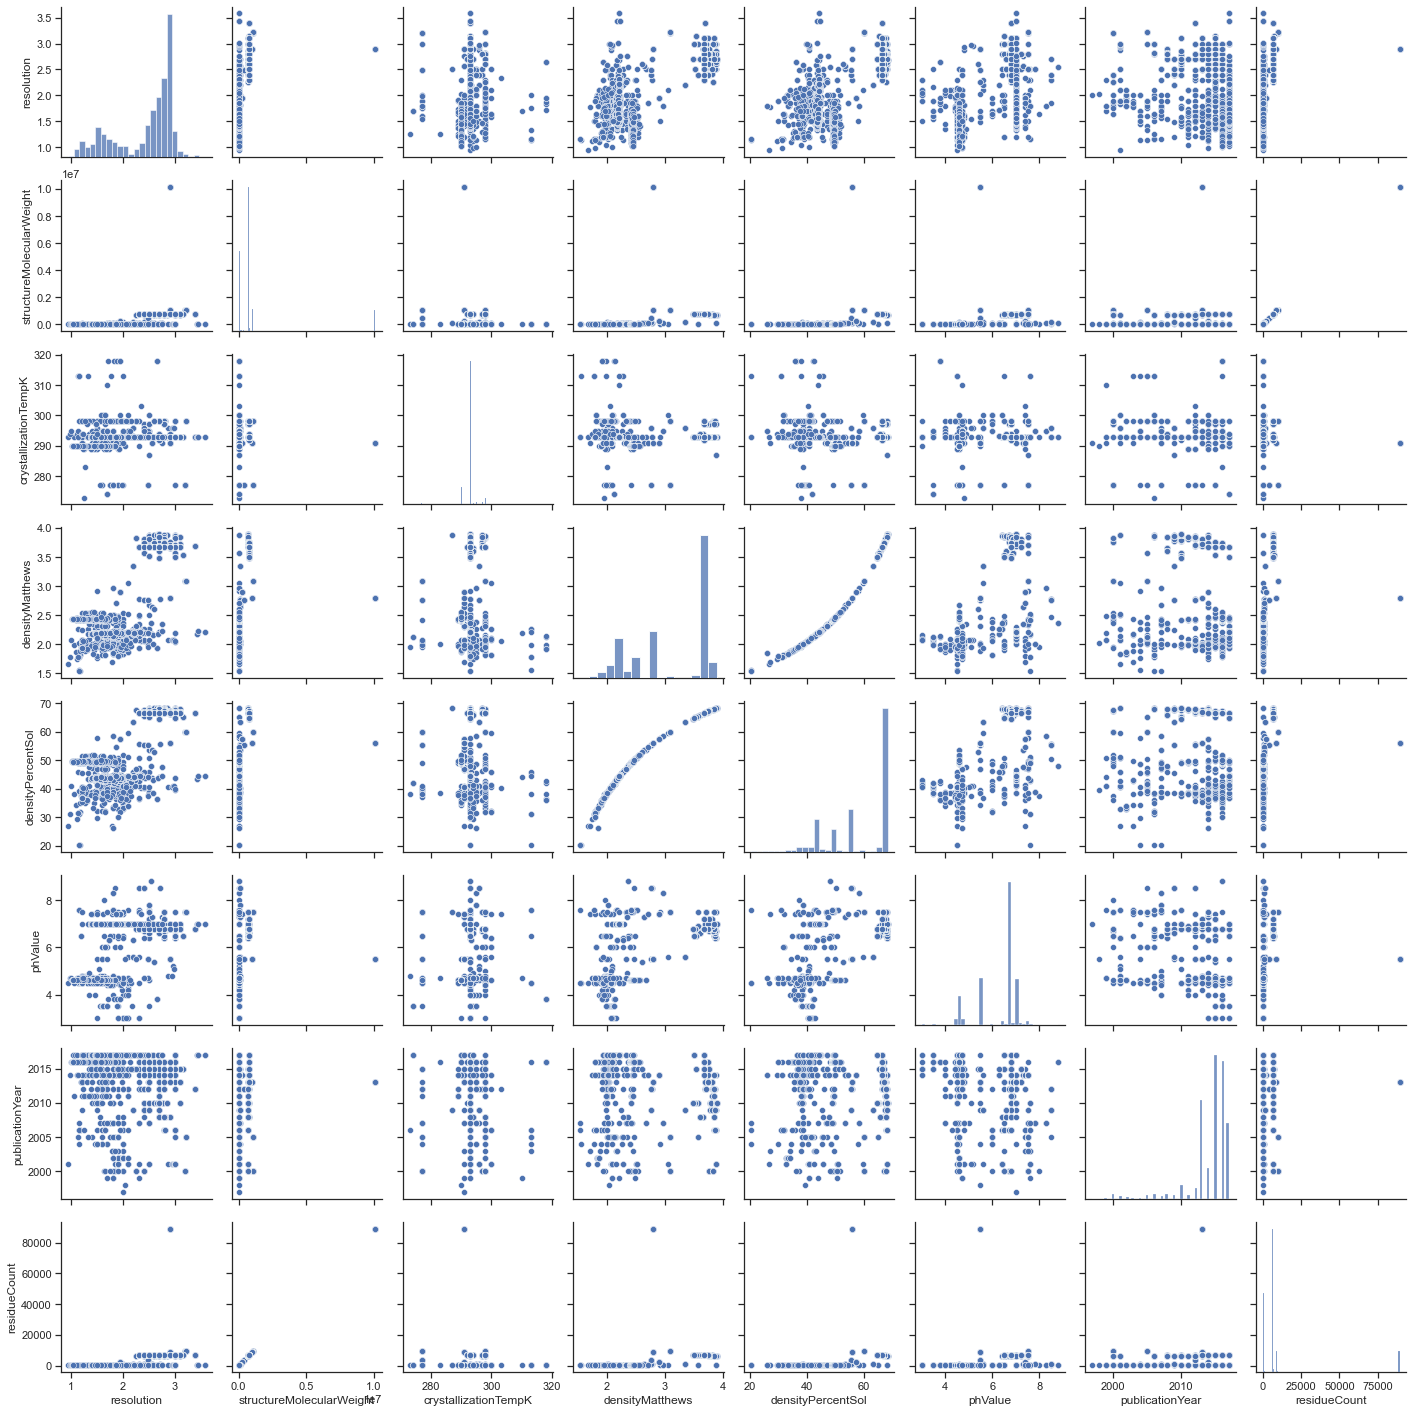

In [20]:
sns.pairplot(df10bs)
sns.set(style="ticks", color_codes=True)

In [14]:
# Vamos a crear un dataframe auxiliar que contenga un fragmento de la cadena, para reducir notación
df10bs_aux = df10bs.copy()
df10bs_aux['sequence'] = df10bs['sequence'].apply(lambda x: x[:20]+'...')

D:\miniconda3\envs\mat281\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\miniconda3\envs\mat281\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


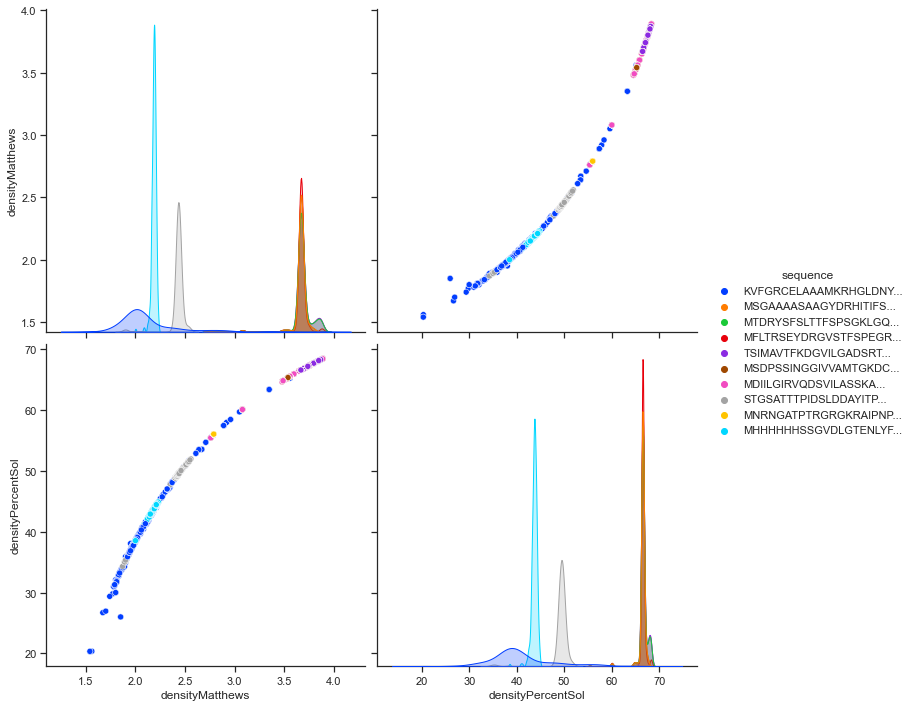

In [22]:
sns.pairplot(df10bs_aux, 
             vars=['densityMatthews', 'densityPercentSol'], 
             palette = "bright",#tab10
             hue="sequence", 
             height = 5)
sns.set(style="ticks", color_codes=True)

D:\miniconda3\envs\mat281\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


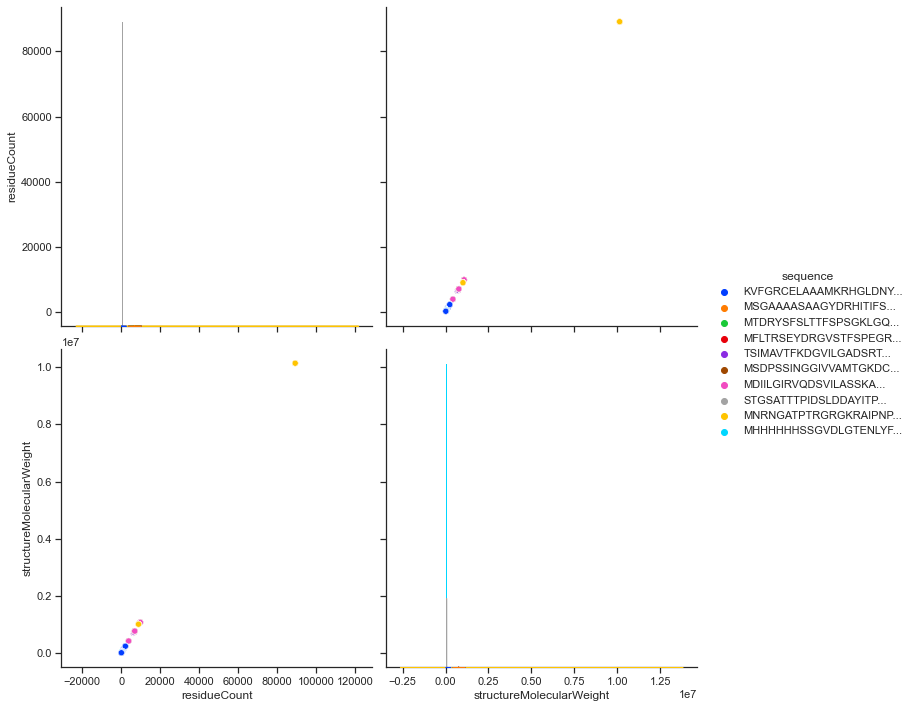

In [23]:
sns.pairplot(df10bs_aux, 
             vars=['residueCount', 'structureMolecularWeight'], 
             palette = "bright",#tab10
             hue="sequence", 
             height = 5)
sns.set(style="ticks", color_codes=True)

In [15]:
df_isnull = pd.DataFrame(round((df1.isnull().sum().sort_values(ascending=False)/df1.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
df_isnull

,Columns,% of Missing Data
0,macromoleculeType,7.500000
1,densityPercentSol,4.700000
2,densityMatthews,4.500000
3,resolution,0.000000
4,sequence,0.000000
5,chainId,0.000000
6,residueCount,0.000000
7,publicationYear,0.000000
8,phValue,0.000000
9,pdbxDetails,0.000000


In [16]:
df_isnull = pd.DataFrame(round((df10bs.isnull().sum().sort_values(ascending=False)/df10bs.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
df_isnull

,Columns,% of Missing Data
0,macromoleculeType,8.000000
1,resolution,0.100000
2,densityPercentSol,0.100000
3,densityMatthews,0.100000
4,residueCount,0.000000
5,sequence,0.000000
6,chainId,0.000000
7,publicationYear,0.000000
8,phValue,0.000000
9,pdbxDetails,0.000000


### ¿Hay que realizar balanceo de datos?

Sí. Como hemos observado tanto para las 10 clasificaciones con más registros y las 10 cadenas con más registros, un porcentaje importante de tipo de macromolécula es 'Proteina', por tanto, habrá que hacer un balanceo.

In [17]:
df10bs_aux["sequence"].value_counts()

MNRNGATPTRGRGKRAIPNP...    720
MHHHHHHSSGVDLGTENLYF...    594
MDIILGIRVQDSVILASSKA...    455
MTDRYSFSLTTFSPSGKLGQ...    455
TSIMAVTFKDGVILGADSRT...    443
KVFGRCELAAAMKRHGLDNY...    406
MSGAAAASAAGYDRHITIFS...    401
MSDPSSINGGIVVAMTGKDC...    401
MFLTRSEYDRGVSTFSPEGR...    400
STGSATTTPIDSLDDAYITP...    399
Name: sequence, dtype: int64

In [18]:
df1["classification"].value_counts()

RIBOSOME                         27866
HYDROLASE                        23559
TRANSFERASE                      18630
OXIDOREDUCTASE                   17541
IMMUNE SYSTEM                     9868
HYDROLASE/HYDROLASE INHIBITOR     9017
LYASE                             6325
TRANSCRIPTION                     4996
VIRAL PROTEIN                     4208
TRANSPORT PROTEIN                 4204
Name: classification, dtype: int64

In [19]:
laux = ["experimentalTechnique", "pdbxDetails", "publicationYear", "structureId", "chainId", "crystallizationMethod", "macromoleculeType"]

In [20]:
auxcl = df1.groupby("classification").sample(n=4204, random_state = 42).drop(labels = laux, axis = 1).drop(labels = ["sequence"], axis = 1).dropna()
auxse = df10bs.groupby("sequence").sample(n=399, random_state = 42).drop(labels = laux, axis = 1).drop(labels = ["classification"], axis = 1).dropna()

In [21]:
auxcl.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
classification,40848.0,10,HYDROLASE/HYDROLASE INHIBITOR,4191,,,,,,,
resolution,40848.0,,,,2.43523,0.696915,0.74,1.95,2.39,2.8,9.5
structureMolecularWeight,40848.0,,,,528867,1.22299e+06,2138.67,58393.5,118829,343858,7.65538e+06
crystallizationTempK,40848.0,,,,291.065,9.33748,4,291,293,295,398
densityMatthews,40848.0,,,,2.89305,1.12116,0.97,2.33,2.7,3.29,99
densityPercentSol,40848.0,,,,54.8476,10.1245,0.52,47.25,54.42,62.61,87.1
phValue,40848.0,,,,6.84089,1.17883,0,6.2,7,7.5,11
residueCount,40848.0,,,,3415.27,6396.65,16,514,1050,3036,57792


In [22]:
auxse.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
resolution,3980.0,,,,2.43398,0.574669,0.94,1.99,2.7,2.9,3.58
structureMolecularWeight,3980.0,,,,1.01691e+06,2.13494e+06,14331.2,36720.6,732349,734793,1.01355e+07
crystallizationTempK,3980.0,,,,292.678,2.63457,273,293,293,293,318
densityMatthews,3980.0,,,,3.16213,0.666436,1.54,2.44,3.67,3.67,3.89
densityPercentSol,3980.0,,,,58.981,10.2895,20.31,49.54,66.52,66.52,68.42
phValue,3980.0,,,,6.32478,0.930193,3,5.5,6.8,6.8,8.8
sequence,3980.0,10,MFLTRSEYDRGVSTFSPEGRLFQVEYSLEAIKLGSTAIGIATKEGV...,399,,,,,,,
residueCount,3980.0,,,,9047.47,18766.9,129,330,6614,6622,89160


### Propuesta de cuatro modelos y sus hiperparámetros asociados.

Se propone utilizar

1. **SVM:** (Support Vector Machines) son un tipo de método de aprendizaje supervisado usando en clasificación, regresión y detección de anomalias.
    - Ventajas
        - Efectivo en bases de datos de gran tamaño
        - Efectivo donde el número de dimensiones es mayor que el número de muestras.
        - Utiliza un conjunto de puntos de training en la función de decision (es decir, vectores de soporte), por tanto es eficiente en el uso de memoria.
    - Desventajas
        - Si el número de variables es mayor que el número de muestras, se debe evitar over-fitting, que es el efecto de sobreentrenar un algoritmo de aprendizaje, pudiendo ajustar características muy especificas que no tienen una relación causal con la función objetivo.
        - No provee estimadores probabilisticos, estos son utilizados usando cross-validation con 5-fold.
    - Hiperparámetros
        - C: (float, default = 1.0) Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C.
        - kernel: ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed', default='rbf') Especifica el tipo de kernel del algoritmo.
        - gamma: ('scale', 'auto' of float, default = 'scale) Coeficiente del kernel para 'rbf', 'poly' y 'sigmoid'.
2. **DTs:** (Decision Trees) son métodos de aprendizaje supervisado no paramétricos usandos para clasificación y regresión.
    - Ventajas
        - Fácil de entender, interpretar y visualizar.
        - Requiere de poca preparación para la data. Por ejemplo, otras técnicas requieres normalizar los datos, utilizar variables dummy y eliminar valores vacíos.
        - Costo de predecir data utilizando el árbol es logaritmica respecto al número de datos utilizado para entrenar al árbol
    - Desventajas
        - Puede generarse overfitting que no permita generalizar los datos bien. Esto puede evitar utilizando mecanismos como pruning, establecer un número minimo de muestras o una profundidad máxima del árbol.
        - Son sensibles a variaciones pequeñas en la data, generando un árbol completamente distinto.
        - Obtener un árbbol de decisión optimo es un problema NP-completo.
        - Puede crear un árbol sesgado si existen clases dominadas.
    - Hiperparámetros
        - criterion: ('gini', 'entropy', default='gini') La función para medir la entropia del árbol.
        - max_depth: (int, default=None) La profundidad maxima del árbol.
        - min_samples_split: (int or float, default = 2) El número minimo de muestras requeridos.
        - min_samples_leaf: (int or float, default = 1) El número minimo de muestras requeridas en un nodo.
3. **AdaBoost:** Es un meta-estimador que realiza un fitting en el dataset original y luego realiza otros fits adicionales sobre el clasificador enfocandose en casos con mayor dificultad. En este caso, se usará sobre DTs.
    - Hiperparámetros
        - n_estimator: número máximo de estimadores.
4. **kNN:** (k-Nearest Neighbors).

In [23]:
Xcl = auxcl.drop(labels = ["classification"], axis = 1)
ycl = auxcl["classification"]
Xse = auxse.drop(labels = ["sequence"], axis = 1)
yse = auxse["sequence"]

In [24]:
Xcl_train, Xcl_test, ycl_train, ycl_test = train_test_split(Xcl, ycl, test_size=0.3, random_state=42)
Xse_train, Xse_test, yse_train, yse_test = train_test_split(Xse, yse, test_size=0.3, random_state=42)

In [25]:
def modelcl_select(classifier):
    cv_result = []
    cv_means = []
    # Cross validate model with Kfold stratified cross val
    auxclas = classifier
    auxclas.fit(Xcl_train, ycl_train)
    pred = auxclas.predict(Xcl_test)
    scor = auxclas.score(Xcl_test, ycl_test)
    kfold = StratifiedKFold(n_splits=5)
    cv_result.append(cross_val_score(classifier, Xcl, y = ycl, scoring = "accuracy", cv = kfold, n_jobs=4))
    cv_means.append(np.mean(cv_result))
    
    return cv_means, pred, scor

def modelse_select(classifier):
    cv_result = []
    cv_means = []
    # Cross validate model with Kfold stratified cross val
    auxclas = classifier
    auxclas.fit(Xse_train, yse_train)
    pred = auxclas.predict(Xse_test)
    scor = auxclas.score(Xse_test, yse_test)
    kfold = StratifiedKFold(n_splits=5)
    cv_result.append(cross_val_score(classifier, Xse, y = yse, scoring = "accuracy", cv = kfold, n_jobs=4))
    cv_means.append(np.mean(cv_result))
    return cv_means, pred, scor

# Fitting all the models 
#El modelo Adaboost no sirve para ser aplicado en los modelos Kneighbors, ni SVC,pues estos no tienen peso.
model_type = [KNeighborsClassifier(), DecisionTreeClassifier(), SVC(),ExtraTreesClassifier(),AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=100),AdaBoostClassifier(ExtraTreesClassifier(),n_estimators=100)]

#modelse = [modelse_select(i) for i in model_type]

#modelcl = [modelcl_select(i) for i in model_type]

In [35]:
##Score Kfold toda la data
#clkfold = np.stack(np.array(modelcl,object)[:,0])
#sekfold = np.stack(np.array(modelse,object)[:,0])
#np.savetxt("scorekfold_class.txt", np.array(clkfold)) 
#np.savetxt("scorekfold_seq.txt", np.array(sekfold))
##Score con la división por test_train_split
#clscore = np.stack(np.array(modelcl,object)[:,2])
#sescore = np.stack(np.array(modelse,object)[:,2])
#np.savetxt("score_class.txt", np.array(clscore)) 
#np.savetxt("score_seq.txt", np.array(sescore))
##Predict con la división por test_train_split
#pd.DataFrame(np.stack(np.array(modelse,object)[:,1])).to_csv("predict_seq.csv")
#pd.DataFrame(np.stack(np.array(modelcl,object)[:,1])).to_csv("predict_class.csv")

In [26]:
skfold_seq=np.loadtxt("scorekfold_seq.txt")
skfold_class=np.loadtxt("scorekfold_class.txt")
score_seq=np.loadtxt("score_seq.txt")
score_class=np.loadtxt("score_class.txt")
predict_seq = pd.read_csv("predict_seq.csv")
predict_class = pd.read_csv("predict_class.csv")

In [27]:
for classifier in model_type:
    classifier.fit(Xse_train, yse_train)
    print(classifier.score(Xse_test,yse_test))

0.4304857621440536
0.40787269681742044
0.28224455611390287
0.4120603015075377
0.41708542713567837


KeyboardInterrupt: 

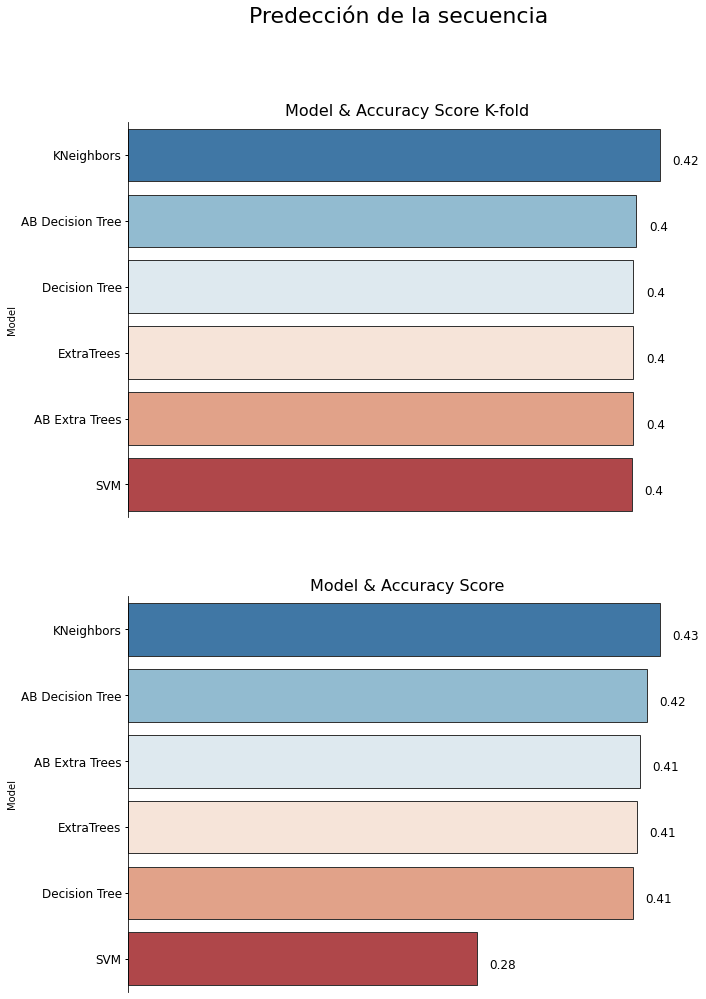

In [28]:
classifier = ['KNeighbors', 'Decision Tree', 'SVM','ExtraTrees','AB Decision Tree','AB Extra Trees']
# Place result in a data Frame
ml_model = pd.DataFrame(skfold_seq,classifier).reset_index()
ml_model.columns=['Model','acc_score']
ml_model.sort_values('acc_score',ascending = False,inplace=True)
ml_model.reset_index(drop=True,inplace = True)
ml_model1 = pd.DataFrame(score_seq,classifier).reset_index()
ml_model1.columns=['Model','acc_score']
ml_model1.sort_values('acc_score',ascending = False,inplace=True)
ml_model1.reset_index(drop=True,inplace = True)

f, ax = plt.subplots(figsize=(10,16), nrows = 2)
plt.suptitle("Predección de la secuencia",fontsize=22)
sns.barplot('acc_score','Model',data=ml_model, ax=ax[0],palette='RdBu_r', edgecolor=".2")
sns.barplot('acc_score','Model',data=ml_model1, ax=ax[1],palette='RdBu_r', edgecolor=".2")
for i in ax[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[0].text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
for i in ax[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[1].text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax[0].tick_params(**kwargs)
ax[1].tick_params(**kwargs)
x_axis = ax[0].axes.get_xaxis().set_visible(False)
x_axis1 = ax[1].axes.get_xaxis().set_visible(False)
ax[0].set_title('Model & Accuracy Score K-fold',fontsize=16)
ax[1].set_title('Model & Accuracy Score',fontsize=16)
sns.despine(bottom=True)
#plt.subplot(1,2,2)
#plt.scatter([1],[1])
plt.show()

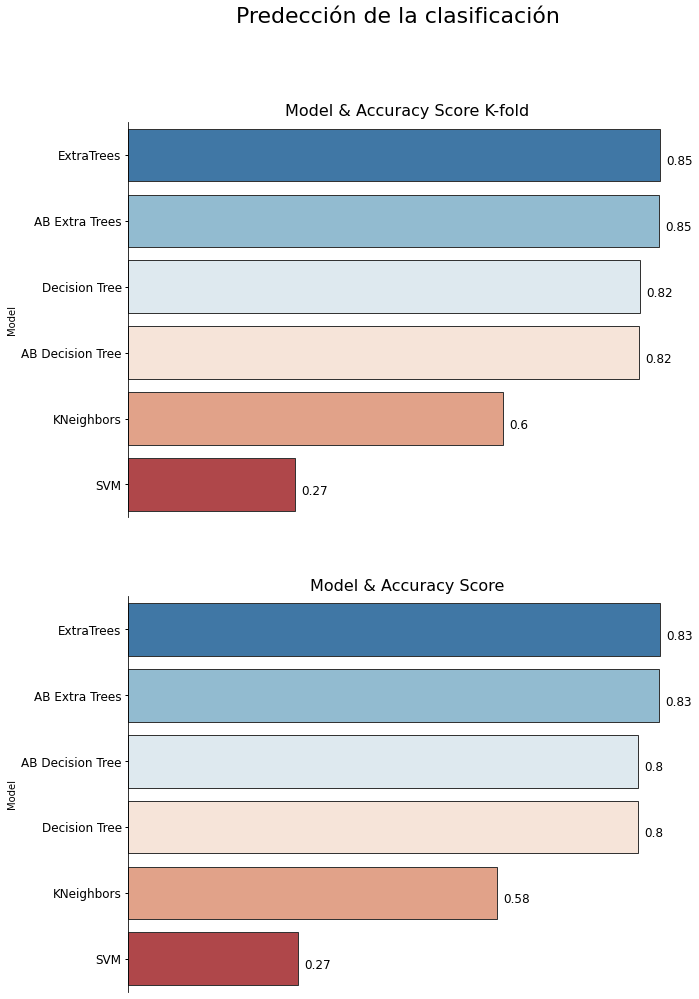

In [29]:
ml_model = pd.DataFrame(skfold_class,classifier).reset_index()
ml_model.columns=['Model','acc_score']
ml_model.sort_values('acc_score',ascending = False,inplace=True)
ml_model.reset_index(drop=True,inplace = True)
ml_model1 = pd.DataFrame(score_class,classifier).reset_index()
ml_model1.columns=['Model','acc_score']
ml_model1.sort_values('acc_score',ascending = False,inplace=True)
ml_model1.reset_index(drop=True,inplace = True)

f, ax = plt.subplots(figsize=(10,16), nrows = 2)
plt.suptitle("Predección de la clasificación",fontsize=22)
sns.barplot('acc_score','Model',data=ml_model, ax=ax[0],palette='RdBu_r', edgecolor=".2")
sns.barplot('acc_score','Model',data=ml_model1, ax=ax[1],palette='RdBu_r', edgecolor=".2")
for i in ax[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[0].text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
for i in ax[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[1].text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax[0].tick_params(**kwargs)
ax[1].tick_params(**kwargs)
x_axis = ax[0].axes.get_xaxis().set_visible(False)
x_axis1 = ax[1].axes.get_xaxis().set_visible(False)
ax[0].set_title('Model & Accuracy Score K-fold',fontsize=16)
ax[1].set_title('Model & Accuracy Score',fontsize=16)
sns.despine(bottom=True)
#plt.subplot(1,2,2)
#plt.scatter([1],[1])
plt.show()

In [30]:
label_mconf = ["HYDROLASE","HYDROLASE/HYDROLASE INHIBITOR", "IMMUNE SYSTEM", "LYASA", "OXIDOREDUCTASE", "RIBOSOME", "TRANSCRIPTION", "TRANSFERASE", "TRANSPORT PROTEIN", "VIRAL PROTEIN"]

In [31]:
def f(Model):
    fig, ax = plt.subplots(figsize=(12,12))
    a = model_type[classifier.index(Model)]
    a.fit(Xcl_train,ycl_train)
    plot_confusion_matrix(a, Xcl_test, ycl_test, ax = ax)
    plt.xticks(rotation=270)
    plt.show()
def g_class(Model):
    df_cm = pd.DataFrame(confusion_matrix(ycl_test, predict_class.T[classifier.index(Model)].values[1:]), label_mconf, label_mconf)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis", fmt='g') # font size
    classificationReport = classification_report(ycl_test, predict_class.T[classifier.index(Model)].values[1:], target_names=label_mconf)
    print("\t\t     Reporte\n\n")
    print(classificationReport)
    plt.show()
def g_seq(Sequence):
    df_cm = pd.DataFrame(confusion_matrix(yse_test, predict_seq.T[classifier.index(Sequence)].values[1:]), label_mconf, label_mconf)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis", fmt='g') # font size
    classificationReport = classification_report(yse_test, predict_seq.T[classifier.index(Sequence)].values[1:], target_names=label_mconf)
    print("\t\t     Reporte\n\n")
    print(classificationReport)
    plt.show()

In [32]:
iplot_class = interactive(g_class, Model = widgets.Dropdown(options=classifier))
iplot_seq = interactive(g_seq, Sequence = widgets.Dropdown(options=classifier))

In [33]:
iplot_class

interactive(children=(Dropdown(description='Model', options=('KNeighbors', 'Decision Tree', 'SVM', 'ExtraTrees…

In [34]:
iplot_seq

interactive(children=(Dropdown(description='Sequence', options=('KNeighbors', 'Decision Tree', 'SVM', 'ExtraTr…

In [72]:
def modelcl_select(modelo):
    model = modelo
    model_grid1 = model_grid[model_type.index(model)]
    print(model_type.index(model))
    model_cv = GridSearchCV(estimator = model,
                        param_grid = model_grid1,
                           cv = 5,
                            scoring = "accuracy",
                           n_jobs=-1)
    model_cv.fit(Xcl_train, ycl_train)
    return model_cv.best_params_,model_cv.best_score_,model_cv.predict(Xcl_test), model_cv.cv_results_

def modelse_select(modelo):
    model = modelo
    model_grid1 = model_grid[model_type.index(model)]
    model_cv = GridSearchCV(estimator = model,
                        param_grid = model_grid1,
                           cv = 5)
    model_cv.fit(Xse_train, yse_train)
    return model_cv.best_params_,model_cv.best_score_,model_cv.predict(Xse_test)
# Fitting all the models 
#El modelo Adaboost no sirve para ser aplicado en los modelos Kneighbors, ni SVC,pues estos no tienen peso.
#modelse = [modelse_select(i) for i in model_type]
param_dictdt = {'criterion': ['gini','entropy'],'min_samples_split': range(2,10,2),'min_samples_leaf': range(1,5)}
param_dictet = {'n_estimators': np.arange(70,130, 15),'criterion': ['gini','entropy'],'min_samples_split': range(2,10),'min_samples_leaf': range(1,5)}
model_type  = [KNeighborsClassifier(), DecisionTreeClassifier(),ExtraTreesClassifier()]
model_grid = [{"n_neighbors" : np.arange(2, 31)},param_dictdt,param_dictet]
#modelcl = [modelcl_select(model_type[0])]
#modelse = [modelse_select(model_type[0])]
#modelse = [modelse_select(i) for i in model_type]
#modelcl = [modelcl_select(i) for i in model_type]

In [54]:
modelcl

[({'n_neighbors': 2},
  0.6351208862342292,
  array(['TRANSCRIPTION', 'OXIDOREDUCTASE', 'OXIDOREDUCTASE', ...,
         'HYDROLASE/HYDROLASE INHIBITOR', 'IMMUNE SYSTEM', 'TRANSCRIPTION'],
        dtype=object))]

In [56]:
modelcl1 = [modelcl_select(model_type[1])]

1


In [59]:
modelcl1

[({'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2},
  0.8200647430736823,
  array(['TRANSCRIPTION', 'OXIDOREDUCTASE', 'OXIDOREDUCTASE', ..., 'LYASE',
         'IMMUNE SYSTEM', 'TRANSCRIPTION'], dtype=object))]

In [73]:
modelcl2 = [modelcl_select(model_type[2])]

2


In [61]:
modelcl2

[({'criterion': 'entropy',
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 115},
  0.8054422214299995,
  array(['TRANSCRIPTION', 'OXIDOREDUCTASE', 'OXIDOREDUCTASE', ..., 'LYASE',
         'IMMUNE SYSTEM', 'TRANSCRIPTION'], dtype=object))]

In [77]:
np.mean(cross_val_score(ExtraTreesClassifier(n_estimators=115, criterion ="entropy"), Xcl, y = ycl, scoring = "accuracy", cv = 5, n_jobs=4))

0.8519145325500634

In [74]:
modelcl2

[({'criterion': 'gini',
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  0.8047427984539548,
  array(['TRANSCRIPTION', 'OXIDOREDUCTASE', 'OXIDOREDUCTASE', ..., 'LYASE',
         'IMMUNE SYSTEM', 'TRANSCRIPTION'], dtype=object),
  {'mean_fit_time': array([3.49201031, 4.12978768, 4.85887847, 5.5820642 , 3.16167455,
          3.79029965, 4.40763378, 5.09813118, 2.83046427, 3.44903221,
          4.02396746, 4.59266973, 2.70699029, 3.28330255, 3.81655045,
          4.43630018, 2.62730622, 3.1621429 , 3.69641562, 4.25523267,
          2.5394074 , 3.03023181, 3.63670878, 4.27491941, 2.46912384,
          2.98377404, 3.51225271, 4.01182818, 2.37046418, 2.94321065,
          3.35773711, 3.85610456, 2.43019223, 2.96332884, 3.48653712,
          3.97693071, 2.48084416, 2.94656219, 3.43836613, 3.96421981,
          2.44486175, 2.96627145, 3.75975051, 4.07211552, 2.44765625,
          2.96397009, 3.3851017 , 3.886519  , 2.35245719, 2.92360311,
          3.39451132, 3.